In [1]:
import lal
import torch
import numpy as np
import jax.numpy as jnp
import lalsimulation as lalsim
import matplotlib.pyplot as plt
from torch import Tensor
from phenom_p import IMRPhenomPv2
from IMRPhenomPv2 import gen_IMRPhenomPv2_hphc, gen_IMRPhenomPv2
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 14,
    "legend.title_fontsize": 16,
    "figure.titlesize": 22,
    "axes.labelpad": 10.0,
}
plt.rcParams.update(params)

/tmp/ipykernel_2292005/2861533109.py:1: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
def ms_to_Mc_eta(m):
    r"""
    Converts binary component masses to chirp mass and symmetric mass ratio.

    Args:
        m: the binary component masses ``(m1, m2)``

    Returns:
        :math:`(\mathcal{M}, \eta)`, with the chirp mass in the same units as
        the component masses
    """
    m1, m2 = m
    return (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5), m1 * m2 / (m1 + m2) ** 2

In [3]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [4]:
m1_msun = Tensor([2])
m2_msun = Tensor([1])
m1_kg = Tensor([m1_msun * lal.MSUN_SI])
m2_kg = Tensor([m2_msun * lal.MSUN_SI])
chi1 = Tensor([0.1])
chi2 = Tensor([0.1])
dist_mpc = Tensor([40])
distance = Tensor([dist_mpc * 1e6 * lal.PC_SI])
tc = Tensor([0])
phic = Tensor([0.2])
inclination = Tensor([0])
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
theta_ripple = jnp.array(
    [
        m1_msun.item(),
        m2_msun.item(),
        0.0,
        0.0,
        chi1.item(),
        0.0,
        0.0,
        chi2.item(),
        dist_mpc.item(),
        tc.item(),
        phic.item(),
        inclination.item(),
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]
fs_torch = Tensor(np.arange(f_l, f_u, df)[1:])

laldict = None
IMRphenom = "IMRPhenomPv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

In [5]:
hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg.item(),
    m2_kg.item(),
    0.0, # this is chi1x
    0.0, # this is chi1y
    chi1.item(), # this is chi1z
    0.0, # this is chi2x
    0.0, # this is chi2y
    chi2.item(), # this is chi2z
    distance.item(),
    inclination.item(),
    phic.item(),
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df
mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

In [6]:
f = freqs_lal[mask_lal]

In [7]:
hp_ripple, hc_ripple = gen_IMRPhenomPv2(fs_ripple, theta_ripple, f_ref)

In [8]:
hp_torch, hc_torch = IMRPhenomPv2(fs_torch, m1_msun, m2_msun, Tensor([0.0]), \
    Tensor([0.0]), chi1, Tensor([0.0]), Tensor([0.0]), chi2, dist_mpc, tc, phic, inclination, Tensor([f_ref]))

# **Jax vs LAL**

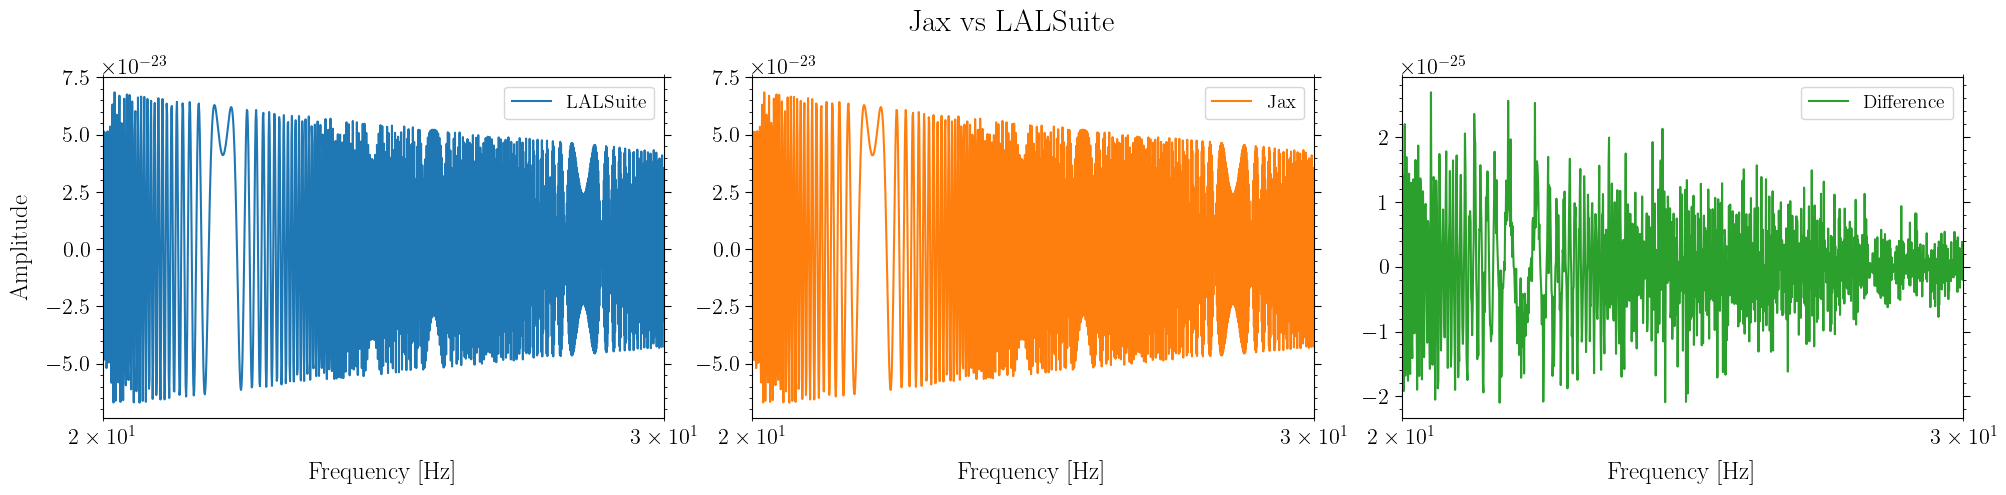

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(f, hp_lalsuite.real, label="LALSuite")
ax[0].set_xscale("log")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")
ax[0].set_xlim(20, 30)
ax[0].legend()

ax[1].plot(f, hp_ripple.real, label="Jax", color="C1")
ax[1].set_xscale("log")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_xlim(20, 30)
ax[1].legend()

ax[2].plot(f, hp_ripple.real-hp_lalsuite.real, label="Difference", color="C2")
ax[2].set_xscale("log")
ax[2].set_xlabel("Frequency [Hz]")
ax[2].set_xlim(20, 30)
ax[2].legend()

fig.suptitle("Jax vs LALSuite")
fig.tight_layout()
plt.show()

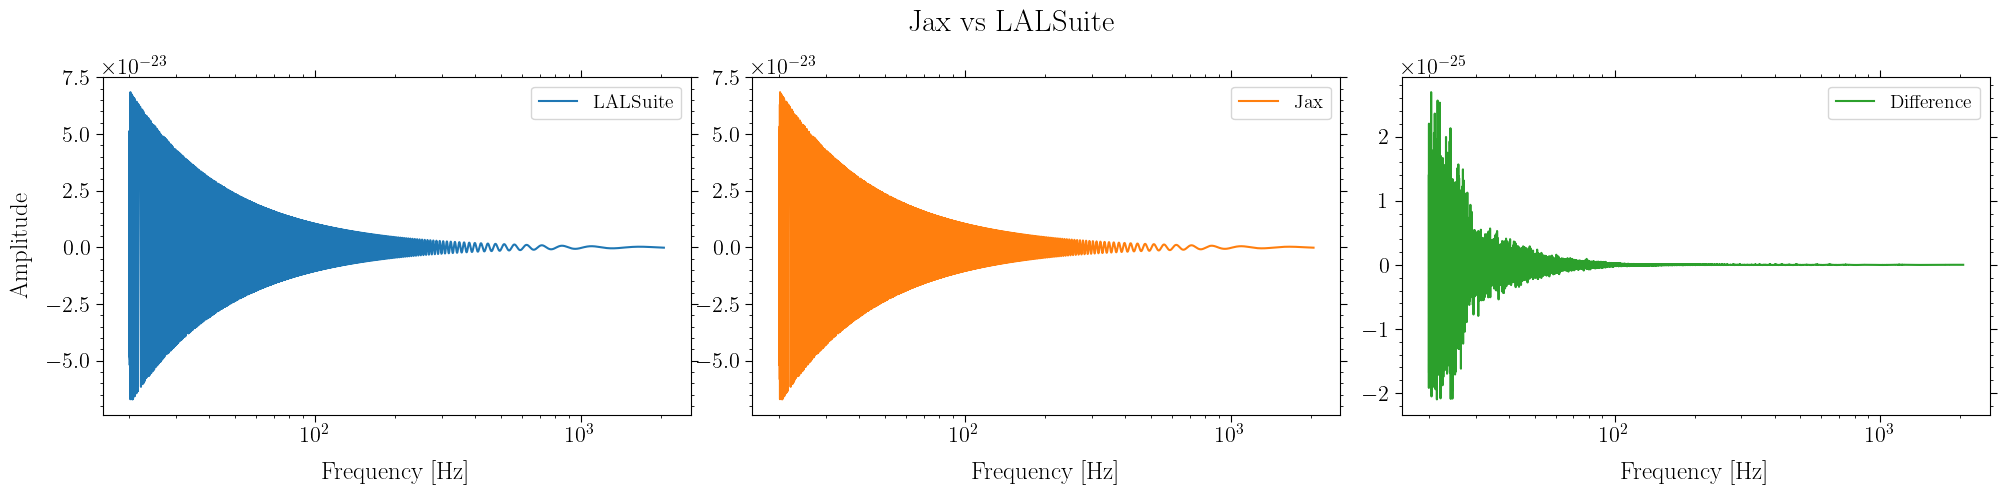

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(f, hp_lalsuite.real, label="LALSuite")
ax[0].set_xscale("log")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

ax[1].plot(f, hp_ripple.real, label="Jax", color="C1")
ax[1].set_xscale("log")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].legend()

ax[2].plot(f, hp_ripple.real-hp_lalsuite.real, label="Difference", color="C2")
ax[2].set_xscale("log")
ax[2].set_xlabel("Frequency [Hz]")
ax[2].legend()

fig.suptitle("Jax vs LALSuite")
fig.tight_layout()
plt.show()

# **Torch vs LAL**

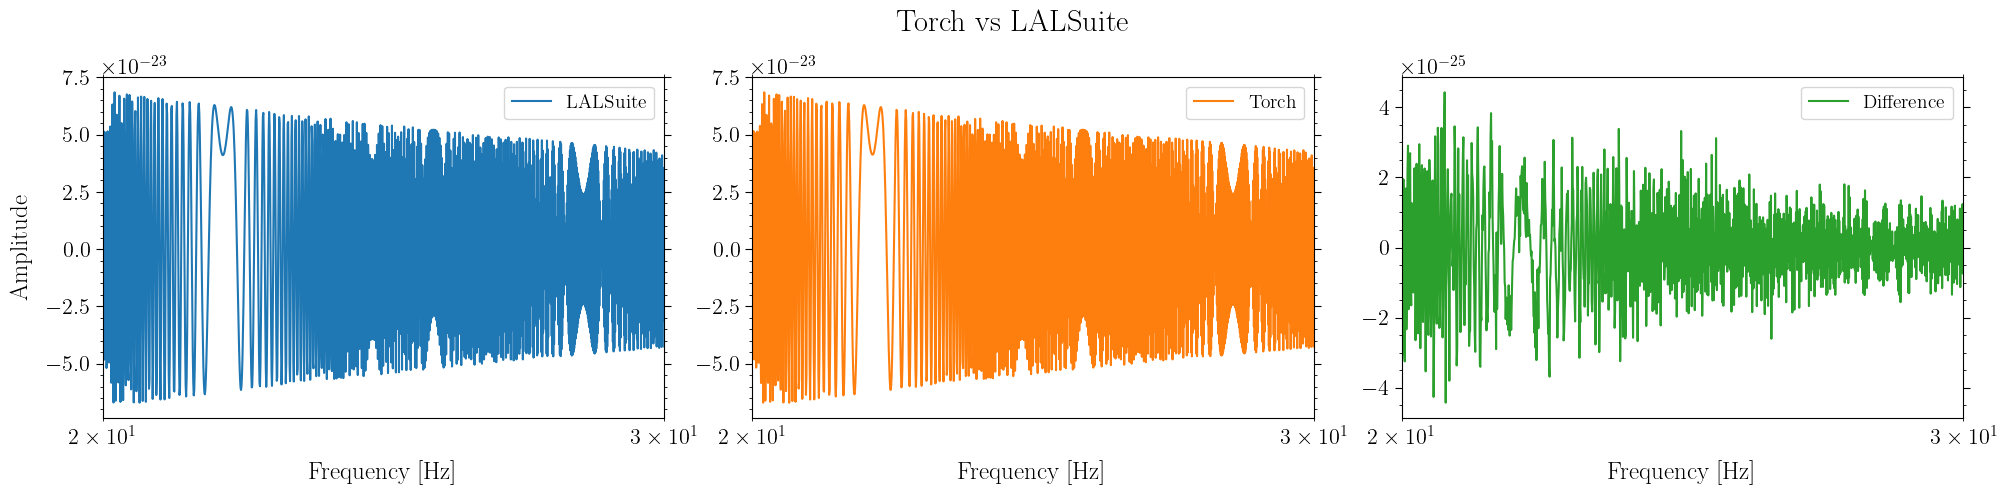

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(f, hp_lalsuite.real, label="LALSuite")
ax[0].set_xscale("log")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")
ax[0].set_xlim(20, 30)
ax[0].legend()

ax[1].plot(f, hp_torch[0].real, label="Torch", color="C1")
ax[1].set_xscale("log")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_xlim(20, 30)
ax[1].legend()

ax[2].plot(f, hp_torch[0].real-hp_lalsuite.real, label="Difference", color="C2")
ax[2].set_xscale("log")
ax[2].set_xlabel("Frequency [Hz]")
ax[2].set_xlim(20, 30)
ax[2].legend()

fig.suptitle("Torch vs LALSuite")
fig.tight_layout()
plt.show()

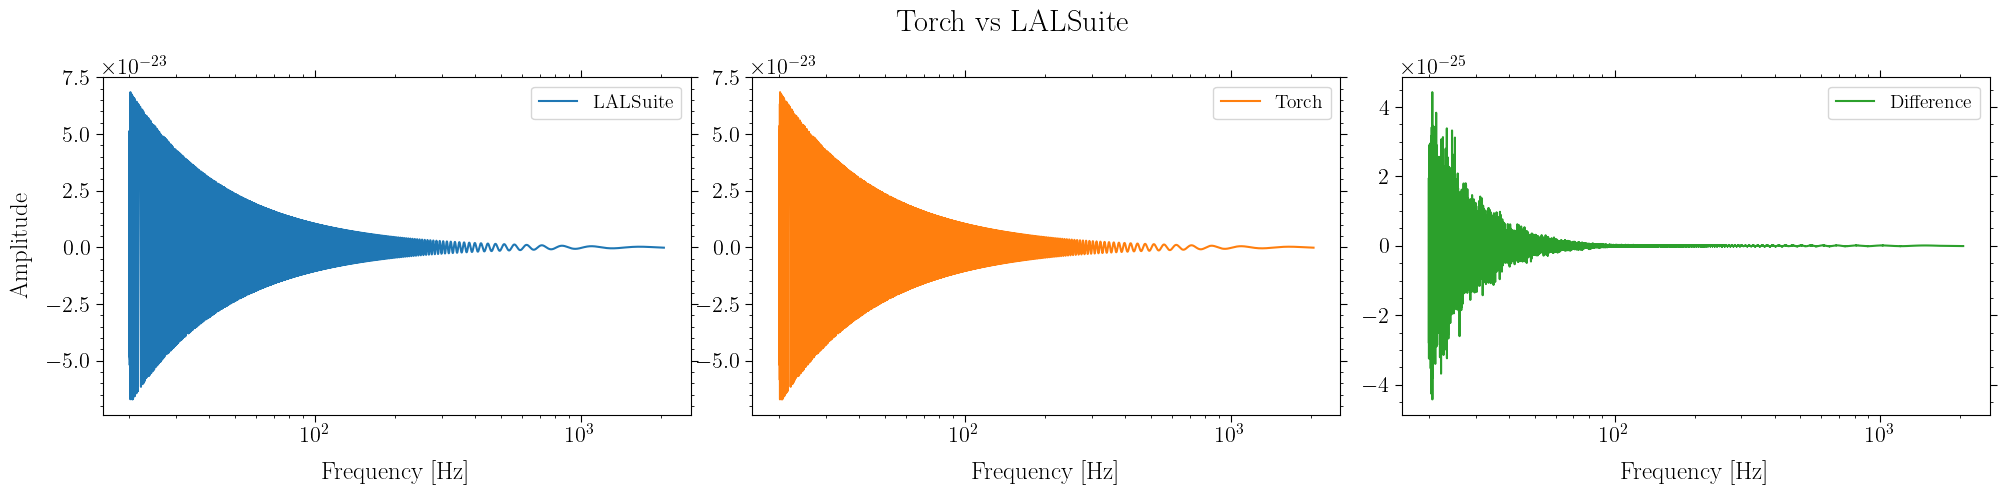

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(f, hp_lalsuite.real, label="LALSuite")
ax[0].set_xscale("log")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

ax[1].plot(f, hp_torch[0].real, label="Torch", color="C1")
ax[1].set_xscale("log")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].legend()

ax[2].plot(f, hp_torch[0].real-hp_lalsuite.real, label="Difference", color="C2")
ax[2].set_xscale("log")
ax[2].set_xlabel("Frequency [Hz]")
ax[2].legend()

fig.suptitle("Torch vs LALSuite")
fig.tight_layout()
plt.show()

# **Torch vs Jax**

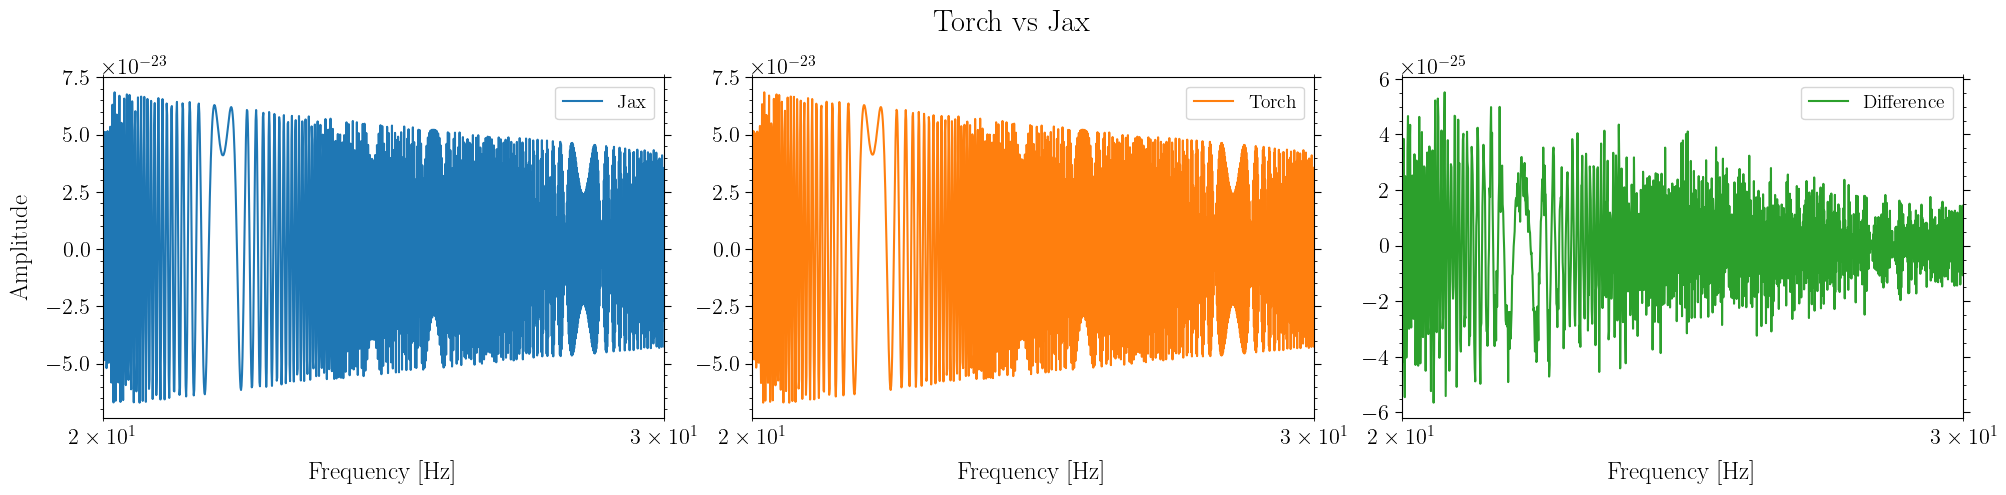

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(f, hp_ripple.real, label="Jax")
ax[0].set_xscale("log")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")
ax[0].set_xlim(20, 30)
ax[0].legend()

ax[1].plot(f, hp_torch[0].real, label="Torch", color="C1")
ax[1].set_xscale("log")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_xlim(20, 30)
ax[1].legend()

ax[2].plot(f, hp_torch[0].real.numpy()-hp_ripple.real, label="Difference", color="C2")
ax[2].set_xscale("log")
ax[2].set_xlabel("Frequency [Hz]")
ax[2].set_xlim(20, 30)
ax[2].legend()

fig.suptitle("Torch vs Jax")
fig.tight_layout()
plt.show()

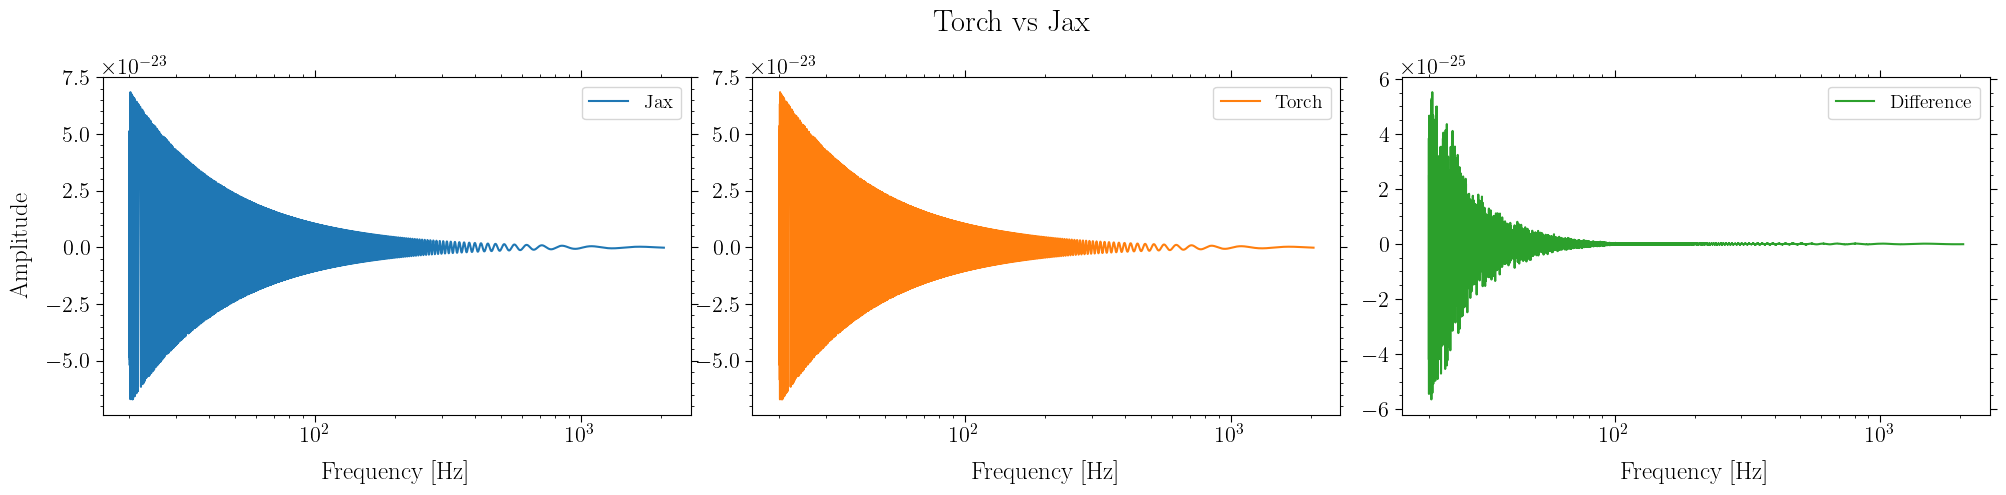

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(f, hp_ripple.real, label="Jax")
ax[0].set_xscale("log")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

ax[1].plot(f, hp_torch[0].real, label="Torch", color="C1")
ax[1].set_xscale("log")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].legend()

ax[2].plot(f, hp_torch[0].real.numpy()-hp_ripple.real, label="Difference", color="C2")
ax[2].set_xscale("log")
ax[2].set_xlabel("Frequency [Hz]")
ax[2].legend()

fig.suptitle("Torch vs Jax")
fig.tight_layout()
plt.show()